# Transfer entropy exploration

In [1]:
import numpy as np
import xarray as xr

from tqdm.notebook import tqdm

from frites.simulations import sim_single_suj_ephy
from frites.conn import conn_te
from cfutils import set_mpl_style
from cfutils.config import PALETTE_RGB_N

from matplotlib import pyplot as plt

set_mpl_style()

np.random.seed(0)

d:\ferreyra\cflab\itpg\.venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\ferreyra\cflab\itpg\.venv\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\ferreyra\cflab\itpg\.venv\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Testing Cholesky problem

In [144]:
n = 500
x = np.random.default_rng().normal(0.0, 1.0, n)
y = x.copy()
y += 0.1 * np.random.rand(n)
xy = np.array([x, y])
cov = np.einsum("ij, kj->ik", xy, xy) / (n - 1.0)
print(cov)
print("positive eigenvalues:", np.all(np.linalg.eigvals(cov) > 0))


[[0.97886485 0.9788031 ]
 [0.9788031  0.97877509]]
positive eigenvalues: True


In [137]:
np.linalg.cholesky(cov)

array([[0.97322095, 0.        ],
       [0.97333847, 0.00575464]])

### Testing Transfer Entropy

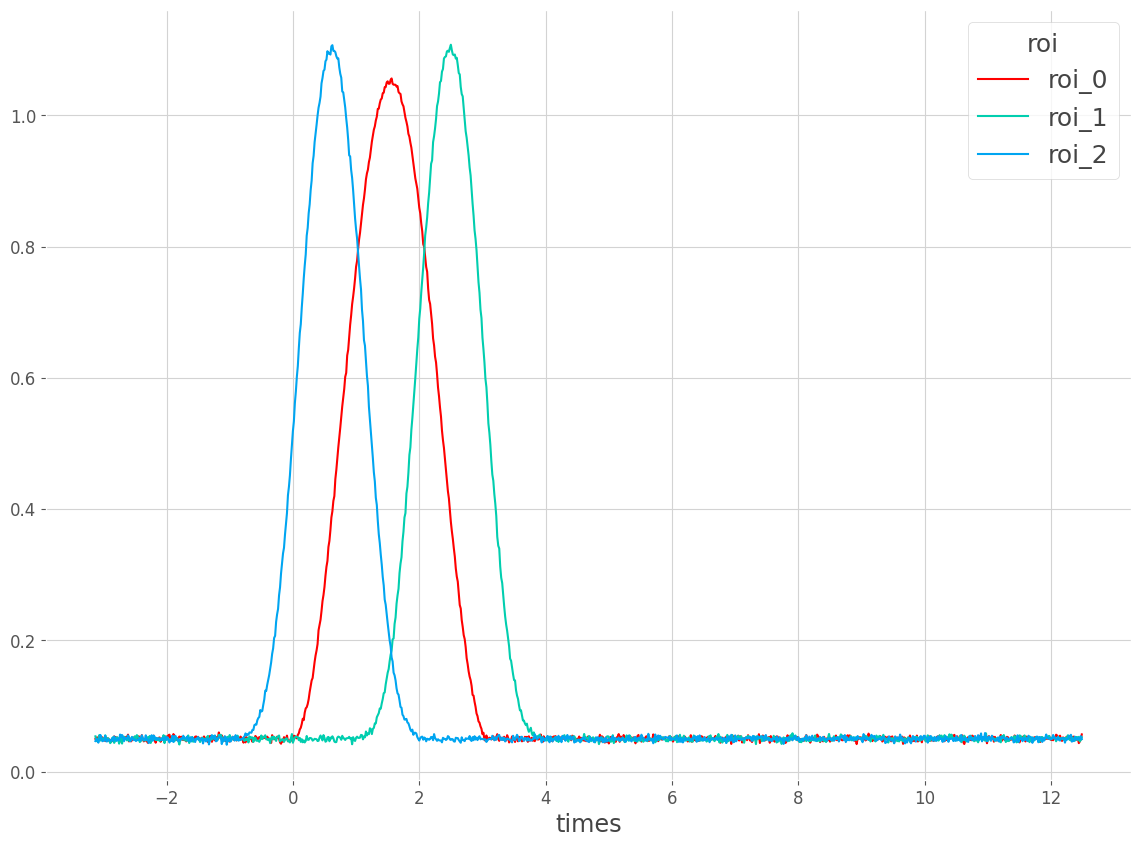

In [176]:
n_trials = 100
n_roi = 3
n_times = 1000
ref = 200
bump_len = 200

trials = np.arange(n_trials)
roi = [f"roi_{k}" for k in range(n_roi)]
times = (np.arange(n_times) - ref) / 64.0

x = 0.1 * np.random.rand(n_trials, n_roi, n_times)
bump = np.hanning(bump_len).reshape(1, -1)

lags = {1: 60, 2: -60}
x[:, 0, ref: ref + bump_len] += bump
for t, lag in lags.items():
    x[:, t, ref + lag: ref + lag + bump_len] += x[:, 0, ref: ref + bump_len] * bump

x = xr.DataArray(x, dims=("trials", "roi", "times"),
                 coords=(trials, roi, times))

x.mean("trials").plot(x="times", hue="roi")
plt.show()


In [164]:
from frites.core import copnorm_nd


(-4.0, 4.0)

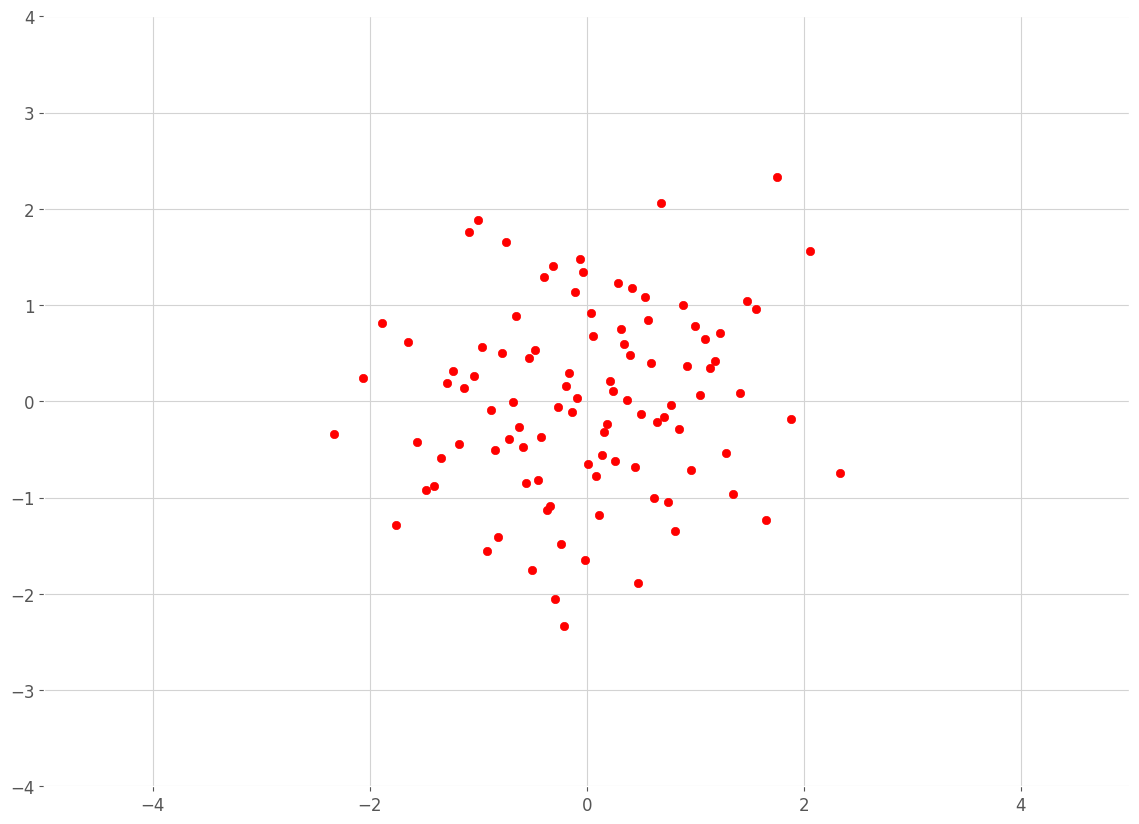

In [175]:
w = 20
lag = 60
x_sel = np.array(
    [x[:, 0, ref : ref + bump_len], x[:, 1, ref + lag : ref + lag + bump_len]]
)
xg = copnorm_nd(x, axis=0)

plt.scatter(xg[:, 0, ref + w], xg[:, 1, ref + lag + w])
plt.xlim([-5, 5])
plt.ylim([-4, 4])

In [ ]:
modality = "meeg"
n_roi = 3
n_epochs = 500
n_times = 1000
x, roi, _ = sim_single_suj_ephy(
    n_epochs=n_epochs, n_times=n_times, modality=modality, n_roi=n_roi, random_state=0
)
trials = np.arange(n_epochs)
times = np.linspace(-1, 1, n_times)

# simulate relationship
# source, target
relationships = [
    {0: slice(550, 650), 1: slice(750, 850)},
    {1: slice(600, 650), 2: slice(700, 750)},
]

for r in relationships:
    region = list(r.keys())
    windows = list(r.values())
    w_s = np.around((times[windows[0].start], times[windows[0].stop]), 3)
    w_t = np.around((times[windows[1].start], times[windows[1].stop]), 3)
    # target = source
    x[:, region[1], windows[1]] += x[:, region[0], windows[0]]
    print(f"|{roi[region[0]]}:{w_s}|->|{roi[region[1]]}:{w_t}|")

# convert to xr
x = xr.DataArray(x, dims=("trials", "roi", "times"), coords=(trials, roi, times))

fig, axs = plt.subplots(n_roi, 1)

for j, ax in enumerate(axs):
    x.mean("trials")[j].plot(x="times", color=PALETTE_RGB_N[j], ax=ax)
    ax.set_xlim([times.min(), times.max()])

for j, r in enumerate(relationships):
    for k, w in r.items():
        axs[k].axvline(times[w.start], color=PALETTE_RGB_N[-1 - j], linestyle="--")
        axs[k].axvline(times[w.stop], color=PALETTE_RGB_N[-1 - j], linestyle="--")


plt.tight_layout()
plt.show()

In [177]:
min_delay, max_delay, step_delay = 50, 100, 1
te = conn_te(
    x,
    times="times",
    roi="roi",
    n_jobs=-1,
    min_delay=min_delay,
    max_delay=max_delay,
    step_delay=step_delay,
    return_delays=False,
)


Defining links (n_roi=3; directed=True; net=False, nb_min_links=None)
Compute Transfer Entropy (n_pairs=6, delays=[50:1:100])
100%|██████████| Estimating TE : 6/6 [00:00<00:00, 3005.59it/s]


In [ ]:
te.times.data

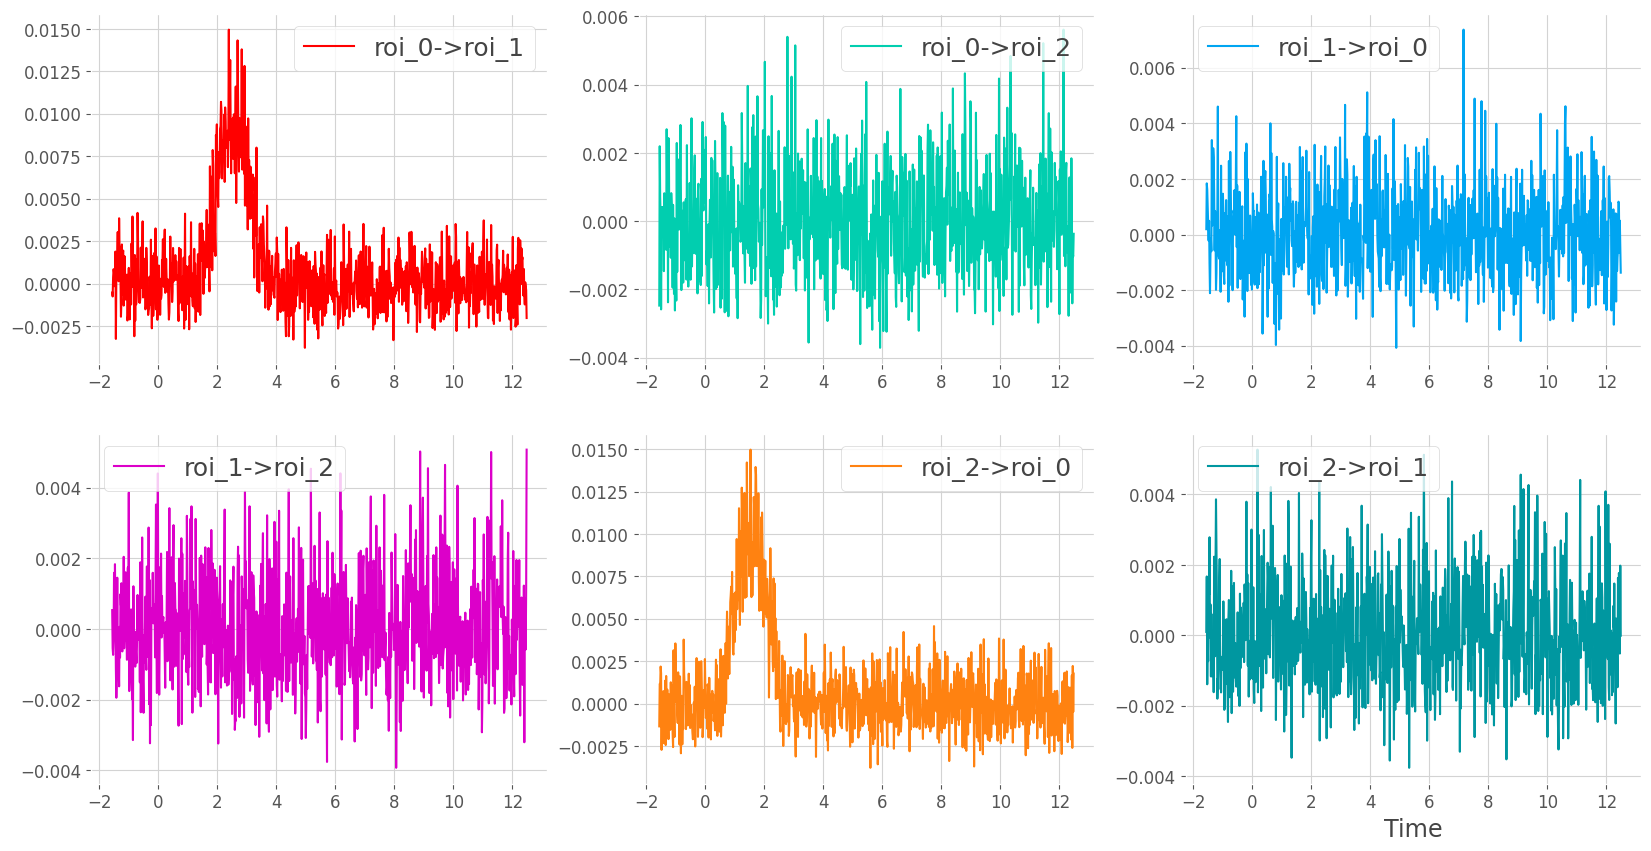

In [178]:
roi_p = te["roi"].data
fig, axes = plt.subplots(2, int(len(roi_p) / 2), figsize=(20, 10))
j = 0
for r, ax in zip(roi_p, axes.flat):
    ax.plot(te.times.data, te.sel(roi=r).T, color=PALETTE_RGB_N[j], label=r)
    ax.legend()
    j += 1

plt.xlabel("Time")
plt.show()